# FLASH1 - Profiles od Ellipsoidal mirrors

### Defining the modules

In [2]:
%matplotlib inline

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


#Importing necessary modules:
import os
import sys
import copy
import time
import errno
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt


from IPython.display import Image

### change `wpg_path` to root folder of the WPG installation


sys.path.insert(0,os.path.join('..','..'))

#change the path to root folder of the WPG installation

#wpg_path = '/Users/lsamoylv/code/ghub/srw_update/'

wpg_path = '/Users/ruizlope/Desktop/WPG-develop\wpg'
sys.path.insert(0,wpg_path)

# wpg_path = os.path.join('..','WPG')

#Import base wavefront class
from wpg import Wavefront

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront,build_gauss_wavefront_xy

#import srwl 
from wpg.srwlib import srwl

#import some helpers functions
from wpg.wpg_uti_exfl import calculate_theta_fwhm_cdr_s1
from wpg.wpg_uti_wf import calc_pulse_energy, averaged_intensity, calculate_fwhm, get_intensity_on_axis
from wpg.wpg_uti_wf import plot_intensity_map, look_at_q_space
from wpg.wpg_uti_wf import plot_wf, look_at_q_space, plot_intensity_qmap
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh
from wpg.useful_code.backpropagation import show_slices

In [4]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

## Design of the Beamlines

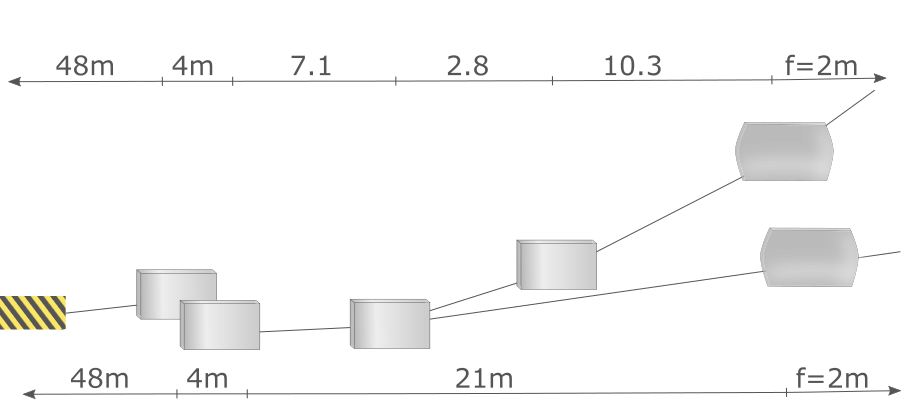

In [5]:
from IPython.display import Image
Image(filename='figures/BL2BL3scketches.png')

## Defining the source

In [129]:
src_to_m0 = 48                                # m
inc_angle = 34.9e-3
wl=24.7e-9                                          # m
w_fwhm =120*1e-6                               # wl/(np.pi*theta_fwhm)# FWHM beam waist; 


############################################################
## Internal calculations ##


w_rms= w_fwhm/1.36
ekev=1239/(wl*1e12)
coh_time= 5e-15                               #[s] parms http://adweb.desy.de/home/faatz/www/FLASH-parms4.html
pulseEnergy= 1e-3;                             #[J]  parms http://adweb.desy.de/home/faatz/www/FLASH-parms4.html
M2=1.59
zR= (np.pi*w_fwhm**2)/(wl*M2)
wZ=w_fwhm*np.sqrt(1+(src_to_m0/zR)**2)
theta_fwhm=wl*M2/(np.pi*w_fwhm)

#defining limits and sample
num_points =512
nslices = 30  
sig_num = 10              #sig_num is at least 5 times the size of the beam width radius;                    
range_xy =w_rms * np.sqrt(1+(src_to_m0/zR)**2)/np.sqrt(2)*sig_num;  
coh_length= 1-(w_fwhm/(1.22*wl*src_to_m0/w_fwhm))


################################################################
## Prints ##

print('Divergence (FWHM)       :{:.2f} urad'.format(theta_fwhm*1e6))
print('Waist FWHM@{:.2f}m      :{:.2f} um'.format(src_to_m0,wZ*1e6))
print('Max. Spatial Coherence  :{:.2f} %'.format(coh_length*100))
print('Range x and y           :{:.2f} mm'.format(range_xy*1e3))

data_path='FLASH1';mkdir_p(data_path)
fname='FLASH1'
bSaved=True

Divergence (FWHM)       :104.17 urad
Waist FWHM@48.00m      :5001.83 um
Max. Spatial Coherence  :99.00 %
Range x and y           :26.01 mm


### Creating the source

saving WF to FLASH1\FLASH1.h5
FWHM at distance 48.0 m: 5.08 x 5.08 mm2


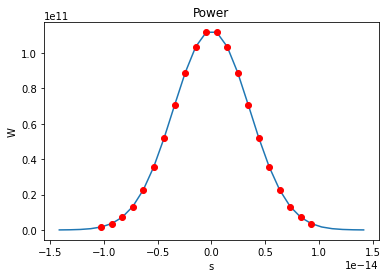

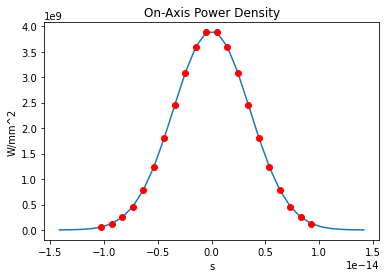

number of meaningful slices: 21
Pulse energy 0.001 J
R-space
(512,) (512,)
FWHM in x = 5.079e-03 m.
FWHM in y = 5.079e-03 m.


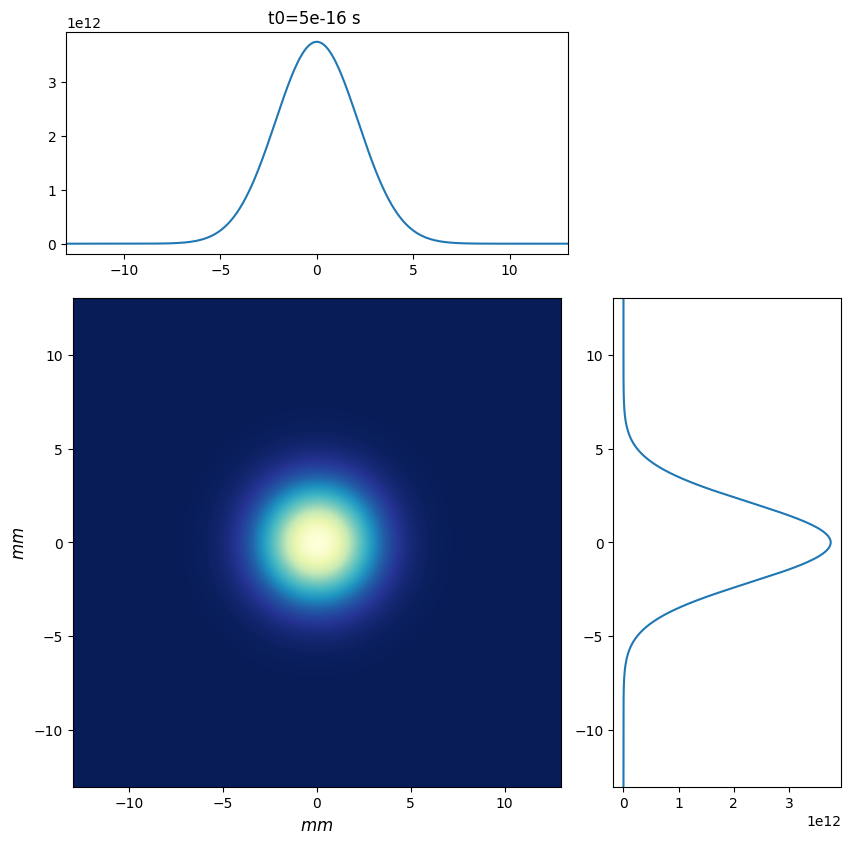

In [130]:
srwl_wf = srwl_wf_00 = build_gauss_wavefront(num_points, num_points, nslices, 
                                ekev, -range_xy/2, range_xy/2, -range_xy/2, range_xy/2, coh_time/np.sqrt(2), 
                                w_rms/2, w_rms/2, src_to_m0, pulseEn=pulseEnergy, 
                                pulseRange=None, _mx=0, _my=0)
wf= Wavefront(srwl_wf);
wf_p=wf.get_intensity().sum(axis=-1);


data_path='FLASH1';mkdir_p(data_path)
fname='FLASH1'



bSaved=True
if bSaved:     
    wf.store_hdf5(os.path.join(data_path,fname+'.h5')); 
    print('saving WF to {:s}'.format(os.path.join(data_path,fname+'.h5')))

fwhm=calculate_fwhm(wf);
print('FWHM at distance {:.1f} m: {:.2f} x {:.2f} mm2'.format(src_to_m0,fwhm[u'fwhm_x']*1e3,fwhm[u'fwhm_y']*1e3));
#plot the source
#plt.imshow(wf_p)
plot_wf(wf, im_aspect='1')


## Defining Optical Elements

#### OPD Maps

In [234]:
mirror_data = np.loadtxt('data_flash1/flash_BL3_ell_residual_height_in_m.dat'); 
offset=-0.285
mirror_data[:,0] += offset 
np.savetxt('data_flash1/flash_BL3_ell_residual_height_in_m2.dat',mirror_data)

In [238]:
%%file beamline_BL3.py

def get_beamline():
    import os
    import wpg
    from wpg import Beamline
    from wpg.optical_elements2 import Aperture, Drift, Empty, Use_PP, Mirror_plane, Mirror_elliptical_mis, VLS_grating 
    from wpg.wpg_uti_oe import show_transmission
    from wpg.srwlib import SRWLOptMirPl, SRWLOptMirSph
    import numpy as np


    mirrors_path = 'data_flash1' #'datacommon'#
    
   
    #Geometry 
    theta_offset=0.0349
    pitch1=0
    pitch2=0
    
    bl = Beamline()
    
    
    #-------2. Elements--------
    
    #OE1: BL0M0 
    PM = Aperture(shape='r', ap_or_ob='a', Dx=0.47, Dy=0.47)
    bl.append(PM, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    PM_distorsions = Mirror_plane(orient='y',
                                  theta=theta_offset, 
                                  length=0.47, 
                                  range_xy=0.0349*0.47, 
                                  filename=os.path.join(
                                  mirrors_path,'flash_PM_M0_1_residual_height_in_m2.dat'),
                                  scale=1, 
                                  x0=0,  
                                  xscale=1., 
                                  bPlot=True)                                         
    bl.append(PM_distorsions,Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    bl.append(Drift(4.0), Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    

    #OE2: BL0M1
    PM2= Aperture(shape='r', ap_or_ob='a', Dx=0.47, Dy=0.47)
    bl.append(PM2, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    PM2_distorsions = Mirror_plane(orient='y',
                                  theta=theta_offset, 
                                  length=0.47, 
                                  range_xy=0.0349*0.47, 
                                  filename=os.path.join(
                                  mirrors_path, 'flash_PM_VLS_residual_height_in_m2.dat'), 
                                  scale=1, 
                                  x0=0, 
                                  xscale=1.,
                                  bPlot=True)                                         
    #print('PM WF distortion'); show_transmission(PM_distorsions);
    bl.append(PM2_distorsions,Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    bl.append(Drift(7.1), Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    
   
   
    
    #OE2: BL3M0
    PM3= Aperture(shape='r', ap_or_ob='a', Dx=0.47, Dy=0.47)
    bl.append(PM3, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    PM3_profile= Mirror_plane(orient='x',
                                theta=0.05235,  
                                length=0.47, 
                                range_xy=0.05235*0.47, 
                                filename=os.path.join(
                                mirrors_path,'perfect_profile.dat'), 
                                scale=1, 
                                x0=0, 
                                xscale=1.,
                                bPlot=True)   
    bl.append(PM3_profile, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    bl.append(Drift(2.8), Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    
    #OE2: BL3M1
    PM4= Aperture(shape='r', ap_or_ob='a', Dx=0.47, Dy=0.47)
    bl.append(PM4, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    PM4_profile= Mirror_plane(orient='x',
                                theta=0.0349,  
                                length=0.47, 
                                range_xy=0.05235*0.47, 
                                filename=os.path.join(
                                mirrors_path,'perfect_profile.dat'), 
                                scale=1, 
                                x0=0, 
                                xscale=1.,
                                bPlot=True)   
    bl.append(PM4_profile, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    bl.append(Drift(10.3), Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
      
    
    

    

    #--2.2. Elliptical mirror BL3M2 --
    
    Eliptical_mirror_ap = Aperture(shape='r', ap_or_ob='a', Dx=0.48, Dy=0.48)
    bl.append(Eliptical_mirror_ap, Use_PP(semi_analytical_treatment=1))
    Emirrorx= Mirror_elliptical_mis(orient='x',
                                p=72.2, 
                                q=2.0,
                                thetaE=0.05235, #3 grades 
                                theta0=0.05235+0.00, 
                                length=0.47,
                                roll=0.00e-3,
                                yaw=0e-6, 
                                distance=0.0)               #horizontal coordinate of central normal vector [m]
    bl.append(Emirrorx, Use_PP(semi_analytical_treatment=0, zoom=1, sampling=1.2))
    Emirrory= Mirror_elliptical_mis(orient='y',
                                p=72.2, 
                                q=2.0,
                                thetaE=0.05235, #3 grades 
                                theta0=0.05235+0.00015, #+0.00035
                                length=0.47,
                                roll=1e-3,#3.0e-3
                                yaw=0.0, 
                                distance=0.0)               #horizontal coordinate of central normal vector [m]
    bl.append(Emirrory, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1.2))
    Emirror_profile= Mirror_plane(orient='x',
                                theta=0.05235,  
                                length=0.47, 
                                range_xy=0.05235*0.47, 
                                filename=os.path.join(
                                mirrors_path,'flash_BL3_ell_residual_height_in_m2.dat'), #flash_BL3_ell_residual_height_in_m2
                                scale=1, 
                                x0=-0.0, 
                                xscale=1.,
                                bPlot=True)                                         
    bl.append(Emirror_profile, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1.2)) 
    bl.append(Drift(1.994+0.055), Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1.2)) 
    #with profile focus is at 1.94m#
    
    
    return bl

Overwriting beamline_BL3.py


### Propagation of the beam through the optics

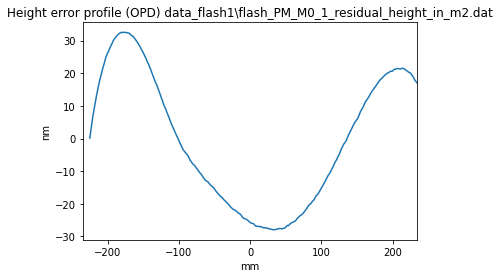

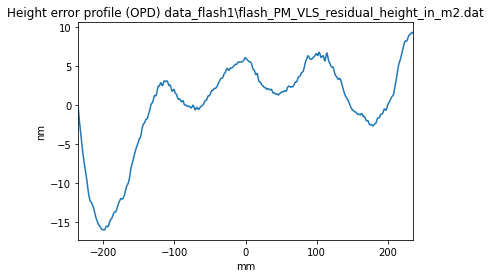

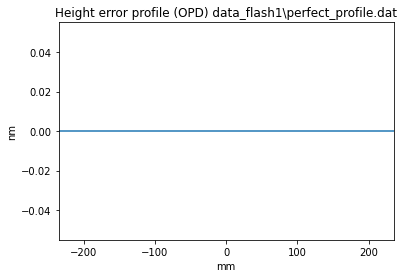

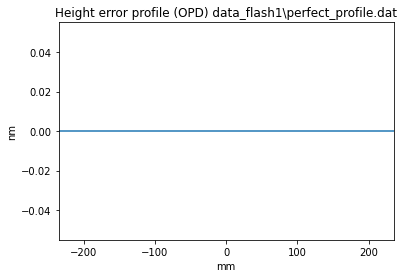

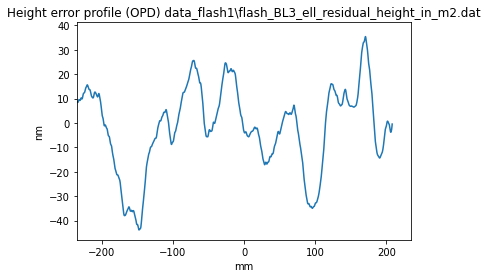

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.47
	Dy = 0.47
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 100
		ny = 1500
		xFin = 0.0082015
		xStart = -0.0082015
		yFin = 0.0082015
		yStart = -0.0082015
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 4.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.47
	Dy = 0.47
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+2

In [239]:
##loading beamline from file
import imp
custom_beamline = imp.load_source('custom_beamline', 'beamline_BL3.py')
get_beamline = custom_beamline.get_beamline
bl = get_beamline()
print(bl)

wft=Wavefront()

full_fname = os.path.join(data_path,fname+'.h5')  # wavefront file
wft.load_hdf5(full_fname)

srwl.SetRepresElecField(wft._srwl_wf, 'f') # <---- switch to frequency domain

bl.propagate(wft)

fwhm=calculate_fwhm(wft);
print('FWHM after propagating: {:.3f} x {:.3f} um2'.format(fwhm[u'fwhm_x']*1e6,fwhm[u'fwhm_y']*1e6)); 

  

-------------------------------------------------
FWHM at focal:80.01 x 179.74 um2 
R-space
(1080,) (1080,)
FWHM in x = 8.001e-05 m.
FWHM in y = 1.797e-04 m.


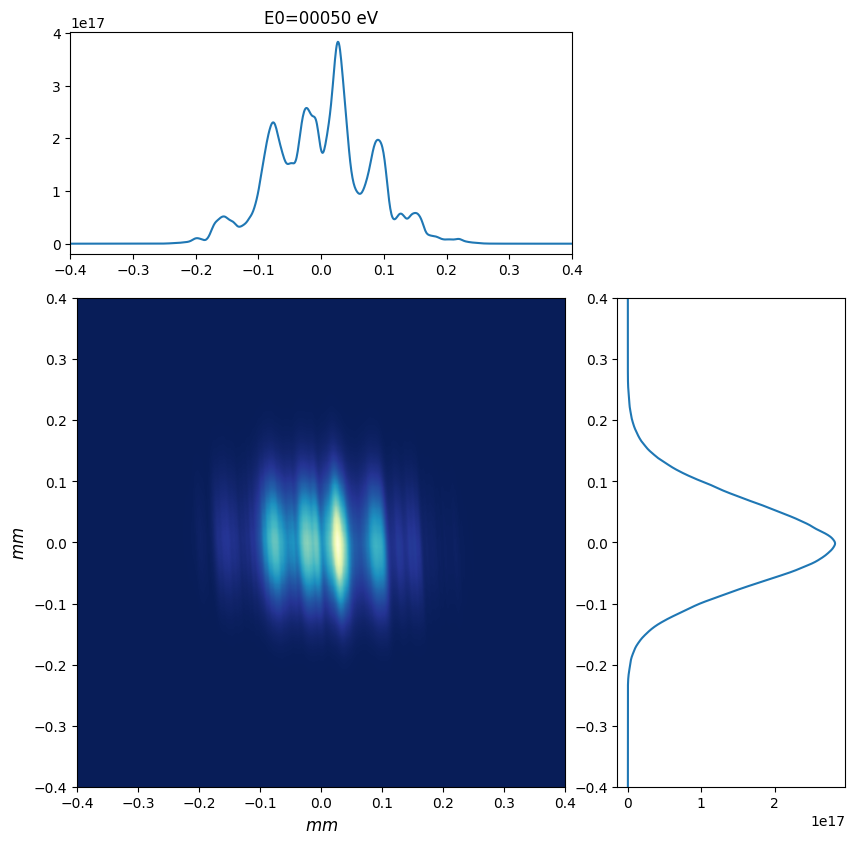

R-space
x and y limit= 0.97 x 0.97


"\nwft_intensity = wft.get_intensity().sum(axis=-1)\ndata_path='BL2';mkdir_p(data_path)\nfname='BL2'\nimport pandas as pd \ndf = pd.DataFrame(wft_intensity)\ndf.to_csv(os.path.join(data_path,fname+'_9p6nm_95urad_1024RES_m34_f27_rollm3.csv'))\n"

In [240]:
#check_sampling(wf)
print('-------------------------------------------------')


xx=calculate_fwhm(wft);
print('FWHM at focal:{:.2f} x {:.2f} um2 '.format(fwhm[u'fwhm_x']*1e6,fwhm[u'fwhm_y']*1e6));
plot_intensity_map(wft, save='', range_x=0.8, range_y=0.8, im_aspect=1);  


xmin, xmax, ymax, ymin = wft.get_limits()
wf_intensity = wft.get_intensity().sum(axis=-1)
print('x and y limit= {:.2f} x {:.2f}'.format(abs(2*xmin*1.e3),abs(2*ymin*1.e3)));

'''
wft_intensity = wft.get_intensity().sum(axis=-1)
data_path='BL2';mkdir_p(data_path)
fname='BL2'
import pandas as pd 
df = pd.DataFrame(wft_intensity)
df.to_csv(os.path.join(data_path,fname+'_9p6nm_95urad_1024RES_m34_f27_rollm3.csv'))
'''

In [162]:
from wpg.wpg_uti_wf import calc_pulse_energy
srwl.SetRepresElecField(wf._srwl_wf, 't') # <---- switch to time domain
calc_pulse_energy(wf)

Number of photons per pulse: 1.244230e+14


0.0009999664390538383